In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
! pip install mne

In [ ]:
import pandas as pd
from glob import glob
import numpy as np
import os

import pywt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from google.cloud import storage
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM, BatchNormalization, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import time


## Functions to read data and load it

In [ ]:


def prepare_data_train(fname):
    """ read and prepare training data """
    # Read data
    data = pd.read_csv(fname)
    # events file
    events_fname = fname.replace('_data','_events')
    # read event file
    labels= pd.read_csv(events_fname)
    clean=data.drop(['id' ], axis=1)#remove id
    labels=labels.drop(['id' ], axis=1)#remove id
    return  clean,labels

In [ ]:
def loading_one_subject(subject_number):
    y_raw= []
    raw = []
    fnames =  sorted(glob('/content/drive/MyDrive/data/hand_motion/train/subj%d_series*_data.csv' % (subject_number)))
    for fname in fnames:
        data,labels=prepare_data_train(fname)
        raw.append(data)
        y_raw.append(labels)
    X = pd.concat(raw).reset_index()
    X.drop(columns="index", inplace=True)
    y = pd.concat(y_raw).reset_index()
    y.drop(columns="index", inplace=True)
    return X, y

In [ ]:
X, y = loading_one_subject(1) 

In [ ]:
X.shape, y.shape


((1422392, 32), (1422392, 6))

In [ ]:
type(X),type(y)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

## Function for mean absolute deviation of a signal and wavelet_denoising

In [ ]:
def convert_df_to_numpy(df):
    return np.asarray(df.astype(float))
  

In [ ]:
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [ ]:
def wavelet_denoising(X, wavelet='db2', level=3):
    coeff = pywt.wavedec(X, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(X)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')

In [ ]:
def preprocess_data(X, y):
    X= convert_df_to_numpy(X)
    y=convert_df_to_numpy(y)
    X=wavelet_denoising(X)
    return X, y

In [ ]:
X, y = preprocess_data(X,y)

In [ ]:
X.shape, y.shape

((1422392, 32), (1422392, 6))

In [ ]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

## Visualizing a signal before and after wavelet denoising

In [ ]:
#signal=pd.read_csv('../raw_date/train/subj1_series1_data.csv')
#signal = signal.drop("id", axis=1)
#filtered = wavelet_denoising(signal, wavelet='db2', level=3)

#import matplotlib.pyplot as plt
#fig, ax = plt.subplots(figsize=(8,5))
#ax.plot(signal.iloc[:10000,1], label='signal', color="b", alpha=0.5,)
#ax.plot(filtered[:10000,1], label='reconstructed signal',color="k")
#ax.legend(loc='upper left')
#ax.set_title('Denoising with DWT')
#plt.show()

## Test splitting data

In [ ]:
def custom_train_test_split(X, y):
     
    splitrate=-X.shape[0]//5*2
    xval=X[splitrate:splitrate//2]
    yval=y[splitrate:splitrate//2]
    xtest=X[splitrate//2:]
    ytest=y[splitrate//2:]
    xtrain=X[:splitrate]
    ytrain=y[:splitrate]
    
    return xtrain, xval, xtest, ytrain, yval, ytest 

In [ ]:
# splitting the data 
xtrain, xval, xtest, ytrain, yval, ytest = custom_train_test_split(X, y)

In [ ]:
xtrain.shape, xval.shape, xtest.shape, ytrain.shape, yval.shape, ytest.shape

((853434, 32),
 (284479, 32),
 (284479, 32),
 (853434, 6),
 (284479, 6),
 (284479, 6))

In [ ]:
type(xtrain), type(xval), type(xtest), type(ytrain), type(yval), type(ytest)

(numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray)

## Scaling data

In [ ]:
scaler= StandardScaler()

def data_scaler_train(X):
    X_prep=scaler.fit_transform(X)
    #do here your preprocessing
    return X_prep
def data_scaler_test(X):
    X_prep=scaler.transform(X)
    #do here your preprocessing
    return X_prep

In [ ]:
X_train_scaled= data_scaler_train(xtrain)
X_val_scaled= data_scaler_test(xval)

In [ ]:
X_train_scaled.shape, X_val_scaled.shape

((853434, 32), (284479, 32))

In [ ]:
type(X_train_scaled), type(X_val_scaled)

(numpy.ndarray, numpy.ndarray)

## Generators

In [ ]:
time_steps = 1000
subsample = 50

In [ ]:
def generator(batch_size, xtrain, ytrain):
    while 1:
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(xtrain)-time_steps)
            x_time_data[i] = xtrain[random_index:random_index+time_steps:subsample]
            yy.append(ytrain[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data.reshape((x_time_data.shape[0],x_time_data.shape[1],  x_time_data.shape[2],1)), yy

In [ ]:
def valgenerator(xval, yval):
    while 1:
        batch_size=32
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(xval)-time_steps)
            x_time_data[i] = xval[random_index:random_index+time_steps:subsample]
            yy.append(yval[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data.reshape((x_time_data.shape[0],x_time_data.shape[1], x_time_data.shape[2],1)), yy

# CNN Model 

In [ ]:
def CNN_model():
  
  load = 1
  model = Sequential()

  model.add(Conv2D(filters = 64, kernel_size = (7,7), padding = "same", activation = "relu", input_shape = ((time_steps//subsample), 32, 1)))
  model.add(BatchNormalization())
  #model.add(MaxPooling2D(pool_size = (3,3)))
  model.add(Conv2D(filters = 64, kernel_size = (5,5), padding = "same", activation = "relu", input_shape = ((time_steps//subsample), 32, 1)))
  model.add(BatchNormalization())
  #model.add(MaxPooling2D(pool_size = (3,3)))
  model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu", input_shape = ((time_steps//subsample), 32, 1)))
  model.add(BatchNormalization())
  #model.add(MaxPooling2D(pool_size = (3,3)))
  model.add(Flatten())
  #model.add(Dropout(0.2))
  model.add(Dense(32, activation = "relu"))
  model.add(BatchNormalization())
  # model.add(Dropout(0.2))
  model.add(Dense(6, activation = "sigmoid"))


  adam = Adam(lr = 0.0001)

  model.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ['accuracy','mse'])

  return model

In [ ]:
model= CNN_model()

In [ ]:
es= EarlyStopping(patience=2)
history =model.fit_generator(generator(32,X_train_scaled, ytrain), steps_per_epoch = 600, epochs = 50,validation_data=valgenerator(X_val_scaled, yval),
                              validation_steps=200,callbacks=[es])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
600/600 [==============================] - 38s 9ms/step - loss: 0.6849 - accuracy: 0.1972 - mse: 0.2440 - val_loss: 0.5582 - val_accuracy: 0.1323 - val_mse: 0.1837
Epoch 2/50
600/600 [==============================] - 5s 8ms/step - loss: 0.5356 - accuracy: 0.2368 - mse: 0.1730 - val_loss: 0.4016 - val_accuracy: 0.1289 - val_mse: 0.1111
Epoch 3/50
600/600 [==============================] - 5s 8ms/step - loss: 0.3644 - accuracy: 0.2442 - mse: 0.0961 - val_loss: 0.2367 - val_accuracy: 0.2316 - val_mse: 0.0487
Epoch 4/50
600/600 [==============================] - 5s 8ms/step - loss: 0.2254 - accuracy: 0.2625 - mse: 0.0460 - val_loss: 0.1565 - val_accuracy: 0.3020 - val_mse: 0.0277
Epoch 5/50
600/600 [==============================] - 5s 8ms/step - loss: 0.1507 - accuracy: 0.2964 - mse: 0.0278 - val_loss: 0.1064 - val_accuracy: 0.2853 - val_mse: 0.0187
Epoch 6/50
600/600 [==============================] - 5s 8ms/step - loss: 0.1144 - accuracy: 0.3200 - mse: 0.0224 - val_loss: 0.0

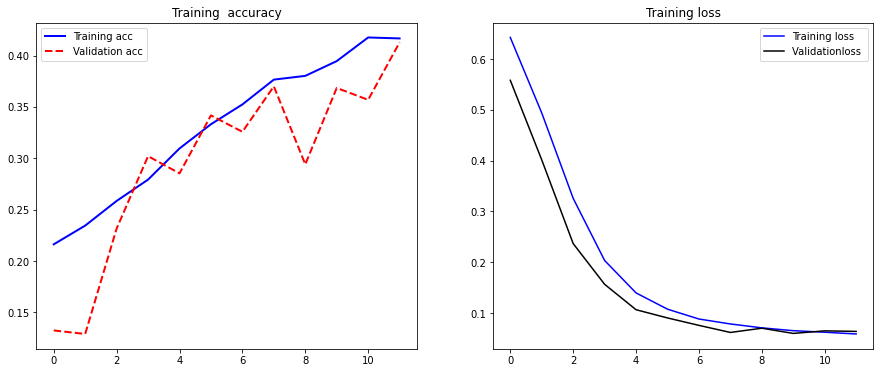

In [ ]:
def plot_training_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
 
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc',linewidth=2)
    plt.plot(epochs, val_acc, 'r--', label='Validation acc',linewidth=2)
    plt.title('Training  accuracy')
    plt.legend()
 
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'k', label='Validationloss ')
    plt.title('Training loss')
    plt.legend()
 
    plt.show()
plot_training_history(history)




In [ ]:
time_frame =1000
steps=50

In [ ]:
def test_generator(xtest, ytest):
    while 1:
        batch_size = 32
        x_time_data = np.zeros((batch_size, time_frame//steps, 32))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(xtest)-time_frame)
            x_time_data[i] = xtest[random_index:random_index+time_frame:steps]
            yy.append(ytest[random_index + time_frame])
        yy = np.asarray(yy)
        yield x_time_data.reshape((x_time_data.shape[0],x_time_data.shape[1], x_time_data.shape[2], 1)), yy

In [ ]:
#final generator for testing 
def batching(xtest, ytest):
  time_frame =1000
  steps=50  
  batch_size = int(len(xtest)/time_frame)
  
  x_time_data = np.zeros((batch_size, time_frame//steps, 32))
  index = 0
  yy = []

  for i in range(batch_size):

    x_time_data[i] = xtest[index:index+time_frame:steps]
            
    yy.append(ytest[index + time_frame -1])

    index+=time_frame

  yy = np.asarray(yy)

  return  x_time_data.reshape((x_time_data.shape[0],x_time_data.shape[1], x_time_data.shape[2], 1)), yy

In [ ]:
def preloaded_predictions(xtest, ytest):
  X_test_scaled = data_scaler_test(xtest)
  x, y = batching(X_test_scaled, ytest)
  predictions= model.predict(x)
  labels = {0 : 'Handstart (HS)',
                   1 : "Grasping (GS)",
                   2 : "Lift (LT)",
                   3 : "Hold (HD)",
                   4 : "Replace (RP)",
                   5 : "Release (RL)"}
  labeled_predictions=[]

  for pred in predictions:
    rounded_pred=np.round(pred)
    movement_index = np.where(rounded_pred == 1)[0]
    if len(movement_index) == 0:
      labeled_predictions.append(["No movement"])
    else:
      movement_labels=[]
      for index in movement_index:
        movement_labels.append(labels[index])
      labeled_predictions.append(movement_labels)   
  return labeled_predictions 

In [ ]:
x, y = batching(X_test_scaled, ytest)

In [ ]:
len(y)

284

In [ ]:
len(preloaded_predictions(xtest, ytest))

284

In [ ]:
all_predictions = preloaded_predictions(xtest, ytest)

In [ ]:
#add the different subjects selection
def search(second_segment_number):
  return all_predictions[second_segment_number]

In [ ]:
#np.round(predictions).flatten().reshape(160000,6)

#np.asarray(y_test_).flatten().reshape(160000,6)
#l=["Handstart (HS)","Grasping (GS)","Lift (LT)","Hold (HD)","Replace (RP)","Release (RL)"]
#print(classification_report(np.asarray(y_test_).flatten().reshape(160000,6), np.round(predictions).flatten().reshape(160000,6), target_names=l))

Predic

In [ ]:
def prediction_labels(gen_data):
    predicted_labels = []
    predictions=[]
    y_test_=[]

    for i in range(1):
      x_test, y_test = next(gen_data)
      while not 1 in y_test:
          x_test, y_test = next(gen_data)
      predicts= model.predict(x_test)
      predictions.append(predicts)
      y_test_.append(y_test)

    labels = {0 : 'Handstart (HS)',
                   1 : "Grasping (GS)",
                   2 : "Lift (LT)",
                   3 : "Hold (HD)",
                   4 : "Replace (RP)",
                   5 : "Release (RL)"}

    for pred in predictions[0]:
      list_to_np =np.asarray(np.round(pred))
      pos_indices = np.where(list_to_np == 1)[1]
      if len(pos_indices) ==0:
          predicted_labels.append('No Movement')
      else:
          list_labeled_mov = []
          for index in pos_indices:
              list_labeled_mov.append(labels[index])
          predicted_labels.append(list_labeled_mov)
    return predicted_labels, y_test_


In [ ]:

#@title Get the segment, preprocess it, scale it, generator, feed it to the model, translate labels (make_prediction function)


In [ ]:
def grab(subj_num,):
  X ,y = loading_one_subject(subj_num)
  X, y = preprocess_data(X,y)
  xtrain, xval, xtest, ytrain, yval, ytest = custom_train_test_split(X, y)
  X_test_scaled = data_scaler_test(xtest)
  gen_data = testing_generator(xtest, ytest, 1000)

  


In [ ]:
#useless functions for now
def tester_generator(xtest, time_steps= 1000, subsample=50):
    while 1:
        batch_size = 1
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        for i in range(batch_size):
            random_index = np.random.randint(0, len(xtest)-time_steps)
            x_time_data[i] = xtest[random_index:random_index+time_steps:subsample]
        yield x_time_data.reshape((x_time_data.shape[0],x_time_data.shape[1], x_time_data.shape[2], 1))



def prediction_test(df, num_test):
  predictions = []
  num_test = num_test
  for i in range(num_test):
      x_test= next(df)
      predict = model.predict(x_test)
      predictions.append(predict)
  l=["Handstart (HS)","Grasping (GS)","Lift (LT)","Hold (HD)","Replace (RP)","Release (RL)"]
  results=[]
  for elem in np.round(predictions):
    if elem[0][0] == 1:
       results.append(l[0])
    if elem[0][1] ==1:
      results.append(l[1])
    if elem[0][2] ==1:
      results.append(l[2])
    if elem[0][3] ==1:
      results.append(l[3])
    if elem[0][4] ==1:
      results.append(l[4])
    if elem[0][5] ==1:
      results.append(l[5])
  return np.reshape(results,(num_test,6))



def scores(gen_data, num_test):
  #scores = []
  predictions=[]
  x_test_=[]
  y_test_=[]
  num_test = num_test
  for i in range(num_test):
      x_test, y_test = next(gen_data)
      while not 1 in y_test:
          x_test, y_test = next(gen_data)
      #score = model.evaluate(x_test, y_test, verbose=0)
      predicts= model.predict(x_test)
      predictions.append(predicts)
      #scores.append(score[1])
      x_test_.append(x_test)
      y_test_.append(y_test)
  #scores = np.asarray(scores)
  #np.mean(scores),
  return  x_test_, y_test_ , predictions
  